In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers, models

In [2]:
df =pd.read_csv("dataset_file_directory.csv")


In [3]:
p5_dataset =df[df['Participant']== 'P05']
p5_datasets =p5_dataset[~p5_dataset['Label'].isin([ 'hunger','request','laughter'])]

In [4]:
classess=p5_datasets['Label'].value_counts()

In [5]:
classess

selftalk        286
frustrated      283
delighted       235
dysregulated    116
happy            61
help             24
Name: Label, dtype: int64

In [6]:
p5_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 2790 to 3817
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     1005 non-null   object
 1   Participant  1005 non-null   object
 2   Label        1005 non-null   object
dtypes: object(3)
memory usage: 31.4+ KB


In [7]:
# Specify the directory where your Python script is located
script_dir = r"C:\Users\pawan\Desktop\mv\downloaddataset"
# Define the relative path to the WAV files directory
wav_dir = os.path.join(script_dir, "downloaded_wav_files")

In [8]:
def extract_audio_features(dataset):
    null_file = 0
    
    for index, row in dataset.iterrows():
        filename = row['Filename']
        participant = row['Participant']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)

        # Check if the audio file exists before attempting to load it
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None) 
                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=13)
                stft = librosa.stft(audio_data)
                fft_features = np.abs(stft)
                rmse = librosa.feature.rms(y=audio_data)
                
                fft_features_db = librosa.amplitude_to_db(fft_features, ref=np.max)

            # Calculate the mean of FFT features
                fft_features_mean = np.mean(fft_features_db, axis=1)
                rmse_mean = np.mean(rmse)
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
                mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)
                
                # Combine the extracted features into a single vector
                combined_mmcs=np.hstack((mfccs_mean,mel_spectrogram_mean,chroma_mean,spectral_contrast_mean))
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, mel_spectrogram_mean, fft_features_mean, rmse_mean))
                mf_mel=np.hstack((mfccs_mean,mel_spectrogram_mean))
                mf_co=np.hstack((mfccs_mean,chroma_mean))
                mf_ch=np.hstack((mfccs_mean,spectral_contrast_mean))
                # Append the extracted features and label to the lists
                mf_ch_list.append(mf_mel)
                mf_co_list.append(mf_ch)
                mf_mel_list.append(mf_co)
                mfcc_fe.append(mfccs_mean)
                rmse_fe.append(rmse_mean)
                chroma_fe.append(chroma_mean)
                spectral_constrast_fe.append(spectral_contrast_mean)
                mel_spectrogram_fe.append(mel_spectrogram_mean)
                fft_fe.append(fft_features_mean)
                combined_4.append(combined_mmcs)
                combined_fe.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file += 1
            print(f"Audio file not found: {wav_file_path}")

    print("Related audio files not found count:", null_file)

    return null_file


In [9]:
mfcc_fe=[]
rmse_fe=[]
chroma_fe=[]
spectral_constrast_fe=[]
mel_spectrogram_fe=[]
fft_fe=[]

#fusion of mfcc+mel,fusion of mfcc + contrast,mfcc+chroma
mf_ch_list=[]
mf_co_list=[]
mf_mel_list=[]
combined_4=[]
labels_list=[]
combined_fe=[]
extract_audio_features(p5_datasets)


Related audio files not found count: 0


0

In [10]:
X_mfcc_fe  = np.array(mfcc_fe)
X_rmse_fe  = np.array(rmse_fe)
X_chroma_fe  = np.array(chroma_fe)
X_spectral_constrast_fe= np.array(spectral_constrast_fe)
X_mel_spectrogram_fe= np.array(mel_spectrogram_fe)
X_fft_fe= np.array(fft_fe)

X_mf_ch=np.array(mf_ch_list)
X_mf_co=np.array(mf_co_list)
X_mf_mel=np.array(mf_mel_list)
X_combined=np.array(combined_4)

y=np.array(labels_list)

In [11]:
X_mel_spectrogram_fe.shape

(1005, 13)

In [12]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train_mfccs, X_test_mfccs, y_train1, y_test1 = train_test_split(X_mfcc_fe, y_encoded, test_size=0.2, random_state=42)
X_train_chroma, X_test_chroma, _, _ = train_test_split(X_chroma_fe, y_encoded, test_size=0.2, random_state=42)
X_train_spectral_contrast, X_test_spectral_contrast, _, _ = train_test_split(X_spectral_constrast_fe, y_encoded, test_size=0.2, random_state=42)
X_train_mel_spectrogram, X_test_mel_spectrogram, _, _ = train_test_split(X_mel_spectrogram_fe, y_encoded, test_size=0.2, random_state=42)
X_train_fft, X_test_fft, _, _ = train_test_split(X_fft_fe, y_encoded, test_size=0.2, random_state=42)
X_train_rmse, X_test_rmse, _, _ = train_test_split(X_rmse_fe, y_encoded, test_size=0.2, random_state=42)

X_mf_ch_train, X_mf_ch_test, _,_ = train_test_split(X_mf_ch, y_encoded, test_size=0.2, random_state=42)
X_mf_co_train, X_mf_co_test, _, _ = train_test_split(X_mf_co, y_encoded, test_size=0.2, random_state=42)
X_mf_mel_train, X_mf_mel_test, _, _ = train_test_split(X_mf_mel, y_encoded, test_size=0.2, random_state=42)
X_combined_train, X_combined_test, _, _ = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)



In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
def cnn_model(X_train,y_train,X_test,y_test):

    model = models.Sequential([
        layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    
        # Add more convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Flatten(),
    
        # Add more dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
    
        layers.Dense(6, activation='softmax') 
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, 
                   validation_split=0.2, 
                    batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    accuracy_stack.append(test_accuracy)
    print(f"Test accuracy: {test_accuracy}")
    
    return model


def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape, )),  # Reshape for 1D convolution

        # Convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.Conv1D(256, 3, activation='relu', padding='same'),

        # Flatten layer
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [16]:
accuracy_stack=[]

In [17]:

cnn_model(X_train_mfccs,y_train1,X_test_mfccs,y_test1)

Epoch 1/50
15/15 [==============================] - 2s 43ms/step - loss: 3.3821 - accuracy: 0.2535 - val_loss: 1.5830 - val_accuracy: 0.3789
Epoch 2/50
15/15 [==============================] - 0s 13ms/step - loss: 1.6516 - accuracy: 0.3048 - val_loss: 1.5070 - val_accuracy: 0.4099
Epoch 3/50
15/15 [==============================] - 0s 13ms/step - loss: 1.6006 - accuracy: 0.3359 - val_loss: 1.3694 - val_accuracy: 0.5280
Epoch 4/50
15/15 [==============================] - 0s 13ms/step - loss: 1.4487 - accuracy: 0.4121 - val_loss: 1.2604 - val_accuracy: 0.5528
Epoch 5/50
15/15 [==============================] - 0s 13ms/step - loss: 1.3896 - accuracy: 0.4355 - val_loss: 1.2273 - val_accuracy: 0.5280
Epoch 6/50
15/15 [==============================] - 0s 13ms/step - loss: 1.3426 - accuracy: 0.4774 - val_loss: 1.1913 - val_accuracy: 0.5466
Epoch 7/50
15/15 [==============================] - 0s 13ms/step - loss: 1.3218 - accuracy: 0.4774 - val_loss: 1.1969 - val_accuracy: 0.5466
Epoch 8/50
15

In [18]:
cnn_model(X_train_chroma,y_train1,X_test_chroma,y_test1)

Epoch 1/50
15/15 [==============================] - 1s 33ms/step - loss: 1.7108 - accuracy: 0.2488 - val_loss: 1.6205 - val_accuracy: 0.2857
Epoch 2/50
15/15 [==============================] - 0s 9ms/step - loss: 1.6258 - accuracy: 0.2893 - val_loss: 1.6162 - val_accuracy: 0.2857
Epoch 3/50
15/15 [==============================] - 0s 9ms/step - loss: 1.6082 - accuracy: 0.2908 - val_loss: 1.5998 - val_accuracy: 0.2857
Epoch 4/50
15/15 [==============================] - 0s 9ms/step - loss: 1.6016 - accuracy: 0.2830 - val_loss: 1.5980 - val_accuracy: 0.3789
Epoch 5/50
15/15 [==============================] - 0s 9ms/step - loss: 1.6083 - accuracy: 0.2784 - val_loss: 1.5886 - val_accuracy: 0.2981
Epoch 6/50
15/15 [==============================] - 0s 9ms/step - loss: 1.5873 - accuracy: 0.2986 - val_loss: 1.5806 - val_accuracy: 0.3975
Epoch 7/50
15/15 [==============================] - 0s 10ms/step - loss: 1.5763 - accuracy: 0.3453 - val_loss: 1.5720 - val_accuracy: 0.3727
Epoch 8/50
15/15 [

In [19]:
cnn_model(X_train_mel_spectrogram,y_train1,X_test_mel_spectrogram,y_test1)

Epoch 1/50
15/15 [==============================] - 1s 31ms/step - loss: 1.7716 - accuracy: 0.2722 - val_loss: 1.6194 - val_accuracy: 0.3975
Epoch 2/50
15/15 [==============================] - 0s 10ms/step - loss: 1.7134 - accuracy: 0.3110 - val_loss: 1.6290 - val_accuracy: 0.3540
Epoch 3/50
15/15 [==============================] - 0s 10ms/step - loss: 1.6457 - accuracy: 0.3250 - val_loss: 1.5803 - val_accuracy: 0.3602
Epoch 4/50
15/15 [==============================] - 0s 10ms/step - loss: 1.6096 - accuracy: 0.3017 - val_loss: 1.5698 - val_accuracy: 0.4099
Epoch 5/50
15/15 [==============================] - 0s 10ms/step - loss: 1.6008 - accuracy: 0.2846 - val_loss: 1.5527 - val_accuracy: 0.4224
Epoch 6/50
15/15 [==============================] - 0s 10ms/step - loss: 1.5656 - accuracy: 0.3406 - val_loss: 1.5393 - val_accuracy: 0.4099
Epoch 7/50
15/15 [==============================] - 0s 10ms/step - loss: 1.5593 - accuracy: 0.3624 - val_loss: 1.5307 - val_accuracy: 0.4224
Epoch 8/50
15

In [20]:

cnn_model(X_train_fft, y_train1, X_test_fft, y_test1)


Epoch 1/50
15/15 [==============================] - 3s 157ms/step - loss: 7.1637 - accuracy: 0.2100 - val_loss: 1.7297 - val_accuracy: 0.2857
Epoch 2/50
15/15 [==============================] - 2s 135ms/step - loss: 1.6968 - accuracy: 0.2675 - val_loss: 1.6449 - val_accuracy: 0.2857
Epoch 3/50
15/15 [==============================] - 2s 134ms/step - loss: 1.6391 - accuracy: 0.2784 - val_loss: 1.6051 - val_accuracy: 0.2857
Epoch 4/50
15/15 [==============================] - 2s 133ms/step - loss: 1.6098 - accuracy: 0.2768 - val_loss: 1.6161 - val_accuracy: 0.2857
Epoch 5/50
15/15 [==============================] - 2s 129ms/step - loss: 1.6487 - accuracy: 0.2224 - val_loss: 1.5938 - val_accuracy: 0.2857
Epoch 6/50
15/15 [==============================] - 2s 129ms/step - loss: 1.6039 - accuracy: 0.2893 - val_loss: 1.5708 - val_accuracy: 0.3975
Epoch 7/50
15/15 [==============================] - 2s 129ms/step - loss: 1.6116 - accuracy: 0.2722 - val_loss: 1.5508 - val_accuracy: 0.3043
Epoch 

In [21]:
X_train_rmse.shape


(804,)

In [22]:

model2=create_cnn_model(1,6)
history = model2.fit(X_train_rmse, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model2.evaluate(X_test_rmse, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/10
15/15 [==============================] - 1s 30ms/step - loss: 1.7623 - accuracy: 0.2659 - val_loss: 1.6921 - val_accuracy: 0.2857
Epoch 2/10
15/15 [==============================] - 0s 9ms/step - loss: 1.6267 - accuracy: 0.2815 - val_loss: 1.6027 - val_accuracy: 0.2857
Epoch 3/10
15/15 [==============================] - 0s 9ms/step - loss: 1.6000 - accuracy: 0.2768 - val_loss: 1.5991 - val_accuracy: 0.2857
Epoch 4/10
15/15 [==============================] - 0s 9ms/step - loss: 1.5860 - accuracy: 0.2706 - val_loss: 1.5885 - val_accuracy: 0.2857
Epoch 5/10
15/15 [==============================] - 0s 10ms/step - loss: 1.5930 - accuracy: 0.2924 - val_loss: 1.5866 - val_accuracy: 0.3168
Epoch 6/10
15/15 [==============================] - 0s 9ms/step - loss: 1.5806 - accuracy: 0.2582 - val_loss: 1.5846 - val_accuracy: 0.3975
Epoch 7/10
15/15 [==============================] - 0s 10ms/step - loss: 1.6001 - accuracy: 0.2519 - val_loss: 1.5864 - val_accuracy: 0.3602
Epoch 8/10
15/15 

In [23]:


model1=create_cnn_model(7,6)
history = model1.fit(X_train_spectral_contrast, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model1.evaluate(X_test_spectral_contrast, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/10
15/15 [==============================] - 1s 33ms/step - loss: 2.0727 - accuracy: 0.2535 - val_loss: 1.5998 - val_accuracy: 0.2919
Epoch 2/10
15/15 [==============================] - 0s 12ms/step - loss: 1.6219 - accuracy: 0.2799 - val_loss: 1.5728 - val_accuracy: 0.3478
Epoch 3/10
15/15 [==============================] - 0s 12ms/step - loss: 1.5798 - accuracy: 0.2955 - val_loss: 1.5579 - val_accuracy: 0.3168
Epoch 4/10
15/15 [==============================] - 0s 12ms/step - loss: 1.5689 - accuracy: 0.3421 - val_loss: 1.5181 - val_accuracy: 0.4348
Epoch 5/10
15/15 [==============================] - 0s 12ms/step - loss: 1.5553 - accuracy: 0.3546 - val_loss: 1.5116 - val_accuracy: 0.3851
Epoch 6/10
15/15 [==============================] - 0s 12ms/step - loss: 1.5128 - accuracy: 0.3748 - val_loss: 1.4483 - val_accuracy: 0.4596
Epoch 7/10
15/15 [==============================] - 0s 13ms/step - loss: 1.4978 - accuracy: 0.3888 - val_loss: 1.4163 - val_accuracy: 0.4658
Epoch 8/10
15

In [24]:
cnn_model(X_mf_ch_train,y_train1,X_mf_ch_test,y_test1)

Epoch 1/50
15/15 [==============================] - 1s 41ms/step - loss: 3.2900 - accuracy: 0.2442 - val_loss: 1.5949 - val_accuracy: 0.3602
Epoch 2/50
15/15 [==============================] - 0s 16ms/step - loss: 1.7474 - accuracy: 0.2737 - val_loss: 1.4647 - val_accuracy: 0.5031
Epoch 3/50
15/15 [==============================] - 0s 15ms/step - loss: 1.5214 - accuracy: 0.3857 - val_loss: 1.3735 - val_accuracy: 0.5217
Epoch 4/50
15/15 [==============================] - 0s 16ms/step - loss: 1.4620 - accuracy: 0.3950 - val_loss: 1.3094 - val_accuracy: 0.5093
Epoch 5/50
15/15 [==============================] - 0s 16ms/step - loss: 1.4022 - accuracy: 0.4666 - val_loss: 1.2303 - val_accuracy: 0.5652
Epoch 6/50
15/15 [==============================] - 0s 15ms/step - loss: 1.3164 - accuracy: 0.4681 - val_loss: 1.1815 - val_accuracy: 0.5590
Epoch 7/50
15/15 [==============================] - 0s 16ms/step - loss: 1.2980 - accuracy: 0.4852 - val_loss: 1.1702 - val_accuracy: 0.5839
Epoch 8/50
15

In [25]:
cnn_model(X_mf_co_train,y_train1,X_mf_co_test,y_test1)

Epoch 1/50
15/15 [==============================] - 1s 38ms/step - loss: 2.9399 - accuracy: 0.2364 - val_loss: 1.5651 - val_accuracy: 0.4534
Epoch 2/50
15/15 [==============================] - 0s 15ms/step - loss: 1.6520 - accuracy: 0.3002 - val_loss: 1.4163 - val_accuracy: 0.4658
Epoch 3/50
15/15 [==============================] - 0s 15ms/step - loss: 1.5430 - accuracy: 0.3468 - val_loss: 1.3977 - val_accuracy: 0.5342
Epoch 4/50
15/15 [==============================] - 0s 16ms/step - loss: 1.4532 - accuracy: 0.4572 - val_loss: 1.3018 - val_accuracy: 0.5093
Epoch 5/50
15/15 [==============================] - 0s 15ms/step - loss: 1.4598 - accuracy: 0.3981 - val_loss: 1.3046 - val_accuracy: 0.5093
Epoch 6/50
15/15 [==============================] - 0s 14ms/step - loss: 1.4168 - accuracy: 0.4495 - val_loss: 1.2711 - val_accuracy: 0.5466
Epoch 7/50
15/15 [==============================] - 0s 16ms/step - loss: 1.3397 - accuracy: 0.4883 - val_loss: 1.2248 - val_accuracy: 0.5342
Epoch 8/50
15

In [26]:
cnn_model(X_mf_mel_train,y_train1,X_mf_mel_test,y_test1)

Epoch 1/50
15/15 [==============================] - 1s 52ms/step - loss: 3.2065 - accuracy: 0.2271 - val_loss: 1.5810 - val_accuracy: 0.2857
Epoch 2/50
15/15 [==============================] - 0s 15ms/step - loss: 1.6478 - accuracy: 0.3204 - val_loss: 1.4641 - val_accuracy: 0.4099
Epoch 3/50
15/15 [==============================] - 0s 16ms/step - loss: 1.5964 - accuracy: 0.3453 - val_loss: 1.4107 - val_accuracy: 0.4099
Epoch 4/50
15/15 [==============================] - 0s 15ms/step - loss: 1.4455 - accuracy: 0.4106 - val_loss: 1.3180 - val_accuracy: 0.4907
Epoch 5/50
15/15 [==============================] - 0s 16ms/step - loss: 1.4368 - accuracy: 0.4401 - val_loss: 1.3029 - val_accuracy: 0.5217
Epoch 6/50
15/15 [==============================] - 0s 17ms/step - loss: 1.3725 - accuracy: 0.4883 - val_loss: 1.2534 - val_accuracy: 0.5155
Epoch 7/50
15/15 [==============================] - 0s 16ms/step - loss: 1.3653 - accuracy: 0.4806 - val_loss: 1.2528 - val_accuracy: 0.5776
Epoch 8/50
15

In [27]:
cnn_model(X_combined_train,y_train1,X_combined_test,y_test1)

Epoch 1/50
15/15 [==============================] - 1s 40ms/step - loss: 2.7924 - accuracy: 0.2519 - val_loss: 1.5656 - val_accuracy: 0.4845
Epoch 2/50
15/15 [==============================] - 0s 17ms/step - loss: 1.6502 - accuracy: 0.2970 - val_loss: 1.5003 - val_accuracy: 0.4845
Epoch 3/50
15/15 [==============================] - 0s 17ms/step - loss: 1.5528 - accuracy: 0.3421 - val_loss: 1.4544 - val_accuracy: 0.4224
Epoch 4/50
15/15 [==============================] - 0s 17ms/step - loss: 1.5287 - accuracy: 0.3717 - val_loss: 1.3488 - val_accuracy: 0.5155
Epoch 5/50
15/15 [==============================] - 0s 18ms/step - loss: 1.4805 - accuracy: 0.4137 - val_loss: 1.3480 - val_accuracy: 0.5155
Epoch 6/50
15/15 [==============================] - 0s 19ms/step - loss: 1.4272 - accuracy: 0.4199 - val_loss: 1.2834 - val_accuracy: 0.5404
Epoch 7/50
15/15 [==============================] - 0s 17ms/step - loss: 1.3643 - accuracy: 0.4759 - val_loss: 1.2049 - val_accuracy: 0.5342
Epoch 8/50
15

In [31]:
accuracy_stack

[0.572139322757721,
 0.3980099558830261,
 0.49253731966018677,
 0.5671641826629639,
 0.3034825921058655,
 0.4129353165626526,
 0.5522388219833374,
 0.5820895433425903,
 0.5522388219833374,
 0.5870646834373474]

In [32]:
labels=p5_datasets['Label'].unique()

In [33]:
labels

array(['happy', 'frustrated', 'dysregulated', 'selftalk', 'delighted',
       'help'], dtype=object)

In [34]:
import time
import matplotlib.pyplot as plt
# Define a function to train and evaluate a CNN model
def train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=10):
    start_time = time.time()

    model = create_cnn_model(input_shape, num_classes)
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    end_time = time.time()

    return model, history, test_accuracy, end_time - start_time

# List of models and their input shapes
models_to_evaluate = [
    (X_train_mfccs, y_train1, X_test_mfccs, y_test1, X_train_mfccs.shape[1], len(set(labels))),
    (X_train_chroma, y_train1, X_test_chroma, y_test1, X_train_chroma.shape[1], len(set(labels))),
    (X_train_mel_spectrogram, y_train1, X_test_mel_spectrogram, y_test1, X_train_mel_spectrogram.shape[1], len(set(labels))),
    (X_train_fft, y_train1, X_test_fft, y_test1, X_train_fft.shape[1], len(set(labels))),
    (X_train_rmse, y_train1, X_test_rmse, y_test1, 1, len(set(labels))),
    (X_train_spectral_contrast, y_train1, X_test_spectral_contrast, y_test1,7, len(set(labels))),
    (X_mf_ch_train, y_train1, X_mf_ch_test, y_test1, X_mf_ch_train.shape[1], len(set(labels))),
    (X_mf_co_train, y_train1, X_mf_co_test, y_test1, X_mf_co_train.shape[1], len(set(labels))),
    (X_mf_mel_train, y_train1, X_mf_mel_test, y_test1, X_mf_mel_train.shape[1], len(set(labels))),
    (X_combined_train, y_train1, X_combined_test, y_test1, X_combined_train.shape[1], len(set(labels)))
]

# Train and evaluate models, and collect their accuracies and execution times
model_accuracies = []
execution_times = []

for X_train, y_train, X_test, y_test, input_shape, num_classes in models_to_evaluate:
    model, _, test_accuracy, execution_time = train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes)
    model_accuracies.append(test_accuracy)
    execution_times.append(execution_time)



Epoch 1/10
15/15 [==============================] - 1s 48ms/step - loss: 3.6347 - accuracy: 0.2488 - val_loss: 1.5632 - val_accuracy: 0.3478
Epoch 2/10
15/15 [==============================] - 0s 27ms/step - loss: 1.5643 - accuracy: 0.3359 - val_loss: 1.3239 - val_accuracy: 0.5590
Epoch 3/10
15/15 [==============================] - 0s 28ms/step - loss: 1.4553 - accuracy: 0.4246 - val_loss: 1.2918 - val_accuracy: 0.5217
Epoch 4/10
15/15 [==============================] - 0s 28ms/step - loss: 1.3406 - accuracy: 0.4946 - val_loss: 1.2134 - val_accuracy: 0.5217
Epoch 5/10
15/15 [==============================] - 0s 27ms/step - loss: 1.2649 - accuracy: 0.4899 - val_loss: 1.1522 - val_accuracy: 0.5466
Epoch 6/10
15/15 [==============================] - 0s 28ms/step - loss: 1.2135 - accuracy: 0.5303 - val_loss: 1.1228 - val_accuracy: 0.6025
Epoch 7/10
15/15 [==============================] - 0s 28ms/step - loss: 1.1471 - accuracy: 0.5552 - val_loss: 1.1133 - val_accuracy: 0.6211
Epoch 8/10
15

15/15 [==============================] - 0s 10ms/step - loss: 1.4986 - accuracy: 0.3966 - val_loss: 1.4167 - val_accuracy: 0.4534
Epoch 7/10
15/15 [==============================] - 0s 10ms/step - loss: 1.4737 - accuracy: 0.4044 - val_loss: 1.4023 - val_accuracy: 0.4783
Epoch 8/10
15/15 [==============================] - 0s 11ms/step - loss: 1.4795 - accuracy: 0.4121 - val_loss: 1.4088 - val_accuracy: 0.4161
Epoch 9/10
15/15 [==============================] - 0s 11ms/step - loss: 1.4337 - accuracy: 0.4215 - val_loss: 1.4377 - val_accuracy: 0.4037
Epoch 10/10
7/7 [==============================] - 0s 3ms/step - loss: 1.3586 - accuracy: 0.4677
Epoch 1/10
15/15 [==============================] - 1s 53ms/step - loss: 2.9968 - accuracy: 0.2333 - val_loss: 1.6719 - val_accuracy: 0.3354
Epoch 2/10
15/15 [==============================] - 0s 34ms/step - loss: 1.6457 - accuracy: 0.3126 - val_loss: 1.4261 - val_accuracy: 0.4907
Epoch 3/10
15/15 [==============================] - 1s 34ms/step - l

In [35]:
print(model_accuracies)
print(" ")
print(accuracy_stack)

[0.6268656849861145, 0.42288556694984436, 0.4427860677242279, 0.3333333432674408, 0.2935323417186737, 0.46766167879104614, 0.6169154047966003, 0.6169154047966003, 0.6368159055709839, 0.611940324306488]
 
[0.572139322757721, 0.3980099558830261, 0.49253731966018677, 0.5671641826629639, 0.3034825921058655, 0.4129353165626526, 0.5522388219833374, 0.5820895433425903, 0.5522388219833374, 0.5870646834373474]


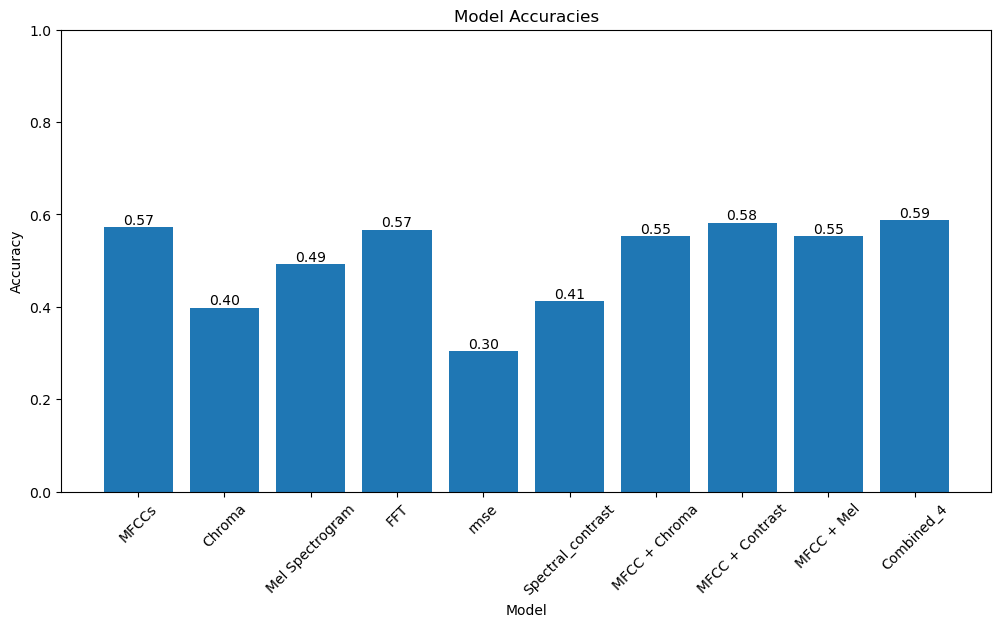

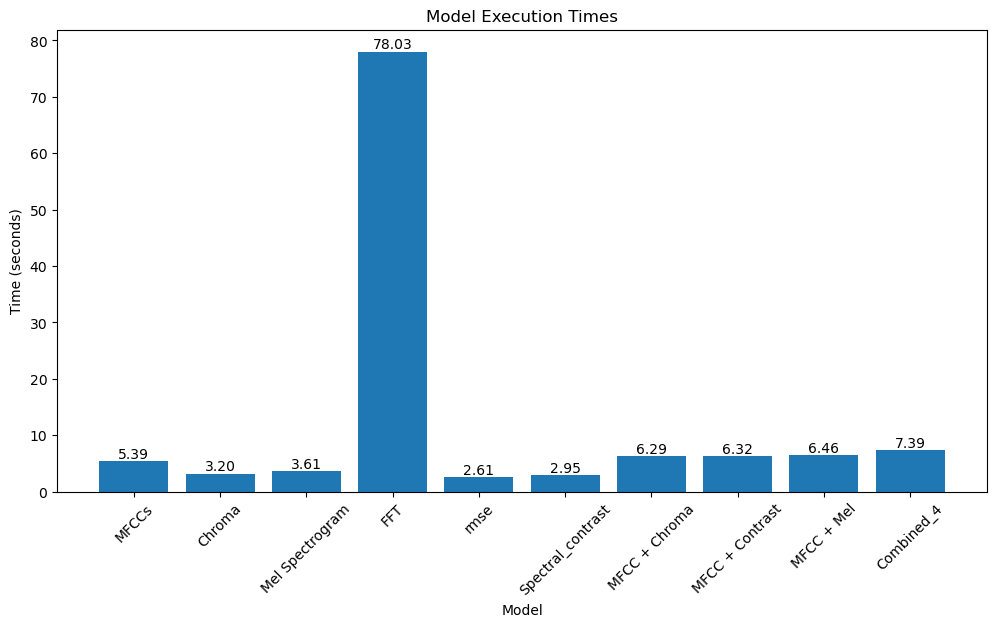

In [37]:

# Plot model accuracies
model_names = [
    "MFCCs", "Chroma", "Mel Spectrogram", "FFT","rmse","Spectral_contrast",
    "MFCC + Chroma", "MFCC + Contrast", "MFCC + Mel","Combined_4"
]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, accuracy_stack)
plt.title("Model Accuracies person-p05")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Annotate each bar with its accuracy value
for bar, accuracy in zip(bars, accuracy_stack):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()
# Plot execution times
plt.figure(figsize=(12, 6))
bar1=plt.bar(model_names, execution_times)
plt.title("Model Execution Times")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
for bar1, time in zip(bar1, execution_times):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{time:.2f}', ha='center', va='bottom')

plt.show()
